## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from time import time
import seaborn as sns

## Preparar os dados

In [2]:
data = np.loadtxt("../data/spiral_d.csv", delimiter=",")
X = data[:, :2].T   # 2 x N
y = data[:, 2]      # N
y = np.where(y==1, 1, -1)

print(data.shape)

(1400, 3)


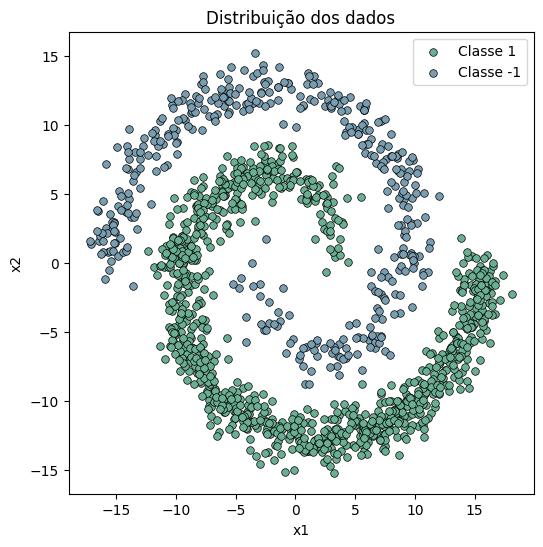

In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(X[0, y==1], X[1, y==1],
            marker='o', color='#6BAF92', edgecolor='black', linewidth=0.5, s=30, label='Classe 1')
plt.scatter(X[0, y==-1], X[1, y==-1],
            marker='o', color='#7A9EB1', edgecolor='black', linewidth=0.5, s=30, label='Classe -1')
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Distribuição dos dados")
plt.legend()
plt.show()

#### Separando dados

In [10]:
# Particionamento 80% treino, 20% teste
N = X.shape[1]
indices = np.arange(N)
np.random.shuffle(indices)
N_train = int(0.8*N)
train_idx = indices[:N_train]
test_idx  = indices[N_train:]

X_train = X[:, train_idx]
y_train = y[train_idx]

X_test  = X[:, test_idx]
y_test  = y[test_idx]

## Classes

### Funções auxiliares

In [ ]:
def show_classification_results(model_name, cm, acc, sensitivity, specificity, precision, f1):
    print(f"{model_name} - Resultados da Classificação:")
    print("\nMatriz de Confusão:")
    print(cm)
    print(f"\nAcurácia: {acc:.3f}")
    print(f"Sensibilidade (Recall da classe positiva): {sensitivity:.3f}")
    print(f"Especificidade (Recall da classe negativa): {specificity:.3f}")
    print(f"Precisão: {precision:.3f}")
    print(f"F1 Score: {f1:.3f}\n")
    
    # Heatmap da matriz de confusão
    plt.figure(figsize=(5,4))
    
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["Positivo (1)", "Negativo (-1)"],
                yticklabels=["Positivo (1)", "Negativo (-1)"])
    
    plt.xlabel("Classe Prevista")
    plt.ylabel("Classe Verdadeira")
    plt.title(f"Matriz de Confusão - {model_name}")
    plt.show()

def confusion_matrix_manual(y_true, y_pred):
    """
    Cria a matriz de confusão:
    TP (1, 1)  FP (1, -1)
    TN (-1, 1) FN (-1, -1)
    """

    TP_std = np.sum((y_true==1) & (y_pred==1))  # Real=1, Prev=1
    FN_std = np.sum((y_true==1) & (y_pred==-1))   # Real=1, Prev=-1
    FP_std = np.sum((y_true==-1) & (y_pred==1))   # Real=-1, Prev=1
    TN_std = np.sum((y_true==-1) & (y_pred==-1))   # Real=-1, Prev=-1
    
    TP = TP_std  # (1, 1)
    FP = FN_std  # (1, -1)
    TN = FP_std  # (-1, 1)
    FN = TN_std  # (-1, -1)

    # Retorna a matriz na estrutura [[TP, FP], [TN, FN]]
    return np.array([[TP, FP],
                     [TN, FN]])

# Métricas
def metrics(cm):
    """
    Calcula métricas a partir da matriz:
    cm = [[TP_usr, FP_usr],
          [TN_usr, FN_usr]]
    """
    TP_usr, FP_usr = cm[0]
    TN_usr, FN_usr = cm[1]
    
    TP = TP_usr
    FN = FP_usr
    FP = TN_usr
    TN = FN_usr

    Total = TP + TN + FP + FN
    acc = (TP+TN) / Total if Total != 0 else 0
    sens = TP/(TP+FN) if (TP+FN)!=0 else 0
    spec = TN/(TN+FP) if (TN+FP)!=0 else 0
    prec = TP/(TP+FP) if (TP+FP)!=0 else 0
    f1 = 2*prec*sens/(prec+sens) if (prec+sens)!=0 else 0
    
    return acc, sens, spec, prec, f1

In [ ]:
class Perceptron:
    def __init__(self, X_train, y_train, learning_rate=1e-3, plot=True, max_epochs=1000):
        self.p, self.N = X_train.shape
        self.X_train = np.vstack((
            -np.ones((1, self.N)), X_train
        ))
        self.d = y_train
        self.lr = learning_rate
        self.w = np.random.random_sample((self.p+1,1)) - 0.5
        self.plot = plot
        self.max_epochs = max_epochs
        self.x1 = np.linspace(-2, 10)
        
        if plot:
            self.fig = plt.figure(1)
            self.ax = self.fig.add_subplot()
            self.ax.scatter(self.X_train[1, self.d[:]==1],
                            self.X_train[2, self.d[:]==1], marker='s', s=120)
            self.ax.scatter(self.X_train[1, self.d[:]==-1],
                            self.X_train[2, self.d[:]==-1], marker='o', s=120)
            self.ax.set_xlim(-1, 7)
            self.ax.set_ylim(-1, 7)
            self.draw_line()
        
    def draw_line(self, c='k', alpha=1, lw=2):
        x2 = -self.w[1,0]/self.w[2,0]*self.x1 + self.w[0,0]/self.w[2,0]
        x2 = np.nan_to_num(x2)
        if self.plot:
            plt.plot(self.x1, x2, c=c, alpha=alpha, lw=lw)
        
    def activation_function(self, u):
        return 1 if u >= 0 else -1
    
    def fit(self):
        epochs = 0
        error = True
        while error and epochs < self.max_epochs:
            error = False
            for k in range(self.N):
                x_k = self.X_train[:, k].reshape(self.p+1, 1)
                u_k = (self.w.T @ x_k)[0,0]
                y_k = self.activation_function(u_k)
                d_k = self.d[k]
                e_k = d_k - y_k
                if e_k != 0:
                    error = True
                self.w = self.w + self.lr * e_k * x_k
            
            if self.plot:
                plt.pause(.4)
                self.draw_line(c='r', alpha=.5)
            epochs += 1
        
        if self.plot:
            plt.pause(.4)
            self.draw_line(c='g', alpha=1, lw=4)
            plt.show()

        plt.figure(figsize=(6,5))
        plt.scatter(self.X_train[1, self.d[:]==1], self.X_train[2, self.d[:]==1], marker='s', s=120, label='Classe 1')
        plt.scatter(self.X_train[1, self.d[:]==-1], self.X_train[2, self.d[:]==-1], marker='o', s=120, label='Classe -1')
        min_x1 = self.X_train[1, :].min() - 1  # Adiciona uma margem
        max_x1 = self.X_train[1, :].max() + 1  # Adiciona uma margem
        x1 = np.linspace(min_x1, max_x1)
        x2 = -self.w[1,0]/self.w[2,0]*x1 + self.w[0,0]/self.w[2,0]
        x2 = np.nan_to_num(x2)
        plt.plot(x1, x2, c='g', lw=4, label='Linha de decisão final')
        plt.xlabel("x1")
        plt.ylabel("x2")
        plt.title(f"Perceptron - Última época ({epochs})")
        plt.legend()
        plt.show()
        if epochs == self.max_epochs:
            misclassified = [k for k in range(self.N) 
            if self.activation_function((self.w.T @ self.X_train[:, k].reshape(self.p+1,1))[0,0]) != self.d[k]]
            print(f'Treinamento interrompido após {epochs} épocas (não convergiu completamente).')
            print("Índices dos exemplos incorretos:", misclassified)
            print("Pesos finais:", self.w.ravel())
        else:
            print(f'Treinamento concluído em {epochs} épocas.')

    def predict(self, X):
        N = X.shape[1]
        y_pred = np.zeros(N)
        for i in range(N):
            x_i = np.vstack((-np.ones((1,1)), X[:,i].reshape(-1,1)))
            y_pred[i] = self.activation_function((self.w.T @ x_i)[0,0])
        return y_pred

In [8]:
class MultilayerPerceptron:
    def __init__(self,X_train:np.ndarray, Y_train:np.ndarray, topology:list, learning_rate = 1e-3, max_epoch=10000, tol = 1e-12):
        '''
        X_train (p x N)
        Y_train (C x N) ou (1 x N) se classificação binária
        '''
        self.p , self.N = X_train.shape
        self.m = Y_train.shape[0]
        
        self.X_train = np.vstack((
            -np.ones((1,self.N)),X_train
        ))
        self.tol = tol
        self.lr = learning_rate
        self.d = Y_train
        topology.append(self.m)
        self.W = [None]*len(topology)
        Z = 0
        for i in range(len(self.W)):
            if i == 0:
                W = np.random.random_sample((topology[i],self.p+1))-.5
            else:
                W = np.random.random_sample((topology[i],topology[i-1]+1))-.5
            self.W[i] = W
            Z += W.size
        print(f"Rede MLP com {Z} parâmetros")
        self.max_epoch = max_epoch
        self.y = [None]*len(topology)
        self.u = [None]*len(topology)
        self.delta = [None]*len(topology)
        
    def g(self, u):
        return (1-np.exp(-u))/(1+np.exp(-u))
    
    def g_d(self, u):
        y = self.g(u)
        return .5*(1-y**2)
    
    def backward(self, e,x):
        for i in range(len(self.W)-1,-1,-1):
            if i == len(self.W)-1:
                self.delta[i] = self.g_d(self.u[i]) * e
                yb = np.vstack((
                    -np.ones((1,1)),
                    self.y[i-1]
                ))
                self.W[i] = self.W[i] + self.lr*(self.delta[i]@yb.T)
            elif i == 0:
                Wnbt = (self.W[i+1][:,1:]).T
                self.delta[i] = self.g_d(self.u[i]) * (Wnbt@self.delta[i+1])
                self.W[i] = self.W[i] + self.lr*(self.delta[i]@x.T)
                
            else:
                Wnbt = (self.W[i+1][:,1:]).T
                self.delta[i] = self.g_d(self.u[i]) * (Wnbt@self.delta[i+1])
                yb = np.vstack((
                    -np.ones((1,1)),
                    self.y[i-1]
                ))
                self.W[i] = self.W[i] + self.lr*(self.delta[i]@yb.T)
            
    
    def forward(self, x):
        
        for i,W in enumerate(self.W):
            if i == 0:
                self.u[i] = W@x
            else:
                yb = np.vstack((
                    -np.ones((1,1)), self.y[i-1]
                ))
                self.u[i] = W@yb                
            self.y[i] = self.g(self.u[i])
         
        
        
    def EQM(self):
        s = 0
        for k in range(self.N):
            x_k = self.X_train[:,k].reshape(self.p+1,1)
            self.forward(x_k)
            y = self.y[-1]
            d = self.d[:,k].reshape(self.m,1)
            e = d - y
            s += np.sum(e**2)
        return s/(2*self.N)
        
    def fit(self):
        epoch = 0
        EQM1 = 1
        self.history = []
        
        while epoch < self.max_epoch and EQM1>self.tol:
            t1 = time()
            for k in range(self.N):
                x_k = self.X_train[:,k].reshape(self.p+1,1)
                #Forward
                self.forward(x_k)
                y = self.y[-1]
                d = self.d[:,k].reshape(self.m,1)
                e = d - y
                #Backward
                self.backward(e,x_k)
            t2 = time()
            EQM1 = self.EQM()
            self.history.append(EQM1)
            epoch+=1
            print(f"Tempo: {t2-t1:.5f}s  Época: {epoch}, EQM: {EQM1:.15f}")

    def predict(self, X):
        """
        Faz a predição para novos dados X (p x N_test)
        Retorna uma matriz de saída (m x N_test)
        """
        N_test = X.shape[1]

        X_bias = np.vstack((-np.ones((1, N_test)), X))
        
        Y_pred = np.zeros((self.m, N_test))
        
        for k in range(N_test):
            x_k = X_bias[:, k].reshape(self.p+1, 1)
            self.forward(x_k)
            Y_pred[:, k] = self.y[-1][:, 0]
        
        return Y_pred


In [ ]:
perceptron = Perceptron(X_train=X_train, y_train=y_train, learning_rate=0.01, plot=False, max_epochs=500)
perceptron.fit()

In [16]:
y_pred_train = perceptron.predict(X_train)
y_pred_test  = perceptron.predict(X_test)

cm_train = confusion_matrix_manual(y_train, y_pred_train)
cm_test  = confusion_matrix_manual(y_test, y_pred_test)

acc_train, sens_train, spec_train, prec_train, f1_train = metrics(cm_train)
acc_test, sens_test, spec_test, prec_test, f1_test = metrics(cm_test)

# Matrizes de confusão
cm_train = confusion_matrix_manual(y_train, y_pred_train)
cm_test  = confusion_matrix_manual(y_test, y_pred_test)

# Métricas
acc_train, sens_train, spec_train, prec_train, f1_train = metrics(cm_train)
acc_test, sens_test, spec_test, prec_test, f1_test = metrics(cm_test)

# Exibição dos resultados
show_classification_results("Perceptron - Treino", cm_train, acc_train, sens_train, spec_train, prec_train, f1_train)
show_classification_results("Perceptron - Teste",  cm_test,  acc_test,  sens_test,  spec_test,  prec_test,  f1_test)

NameError: name 'perceptron' is not defined

In [53]:
# Preparar labels para MLP (1 x N)
Y_train_mlp = y_train.reshape(1, -1)
Y_test_mlp  = y_test.reshape(1, -1)

# Criar MLP (topologia: camadas ocultas com 15, 10 e 5 neurônios)
mlp = MultilayerPerceptron(X_train=X_train, Y_train=Y_train_mlp, topology=[15, 10, 5], learning_rate=0.0004, max_epoch=500)
mlp.fit()

Rede MLP com 266 parâmetros
Tempo: 0.29794s  Época: 1, EQM: 0.429444936681386
Tempo: 0.17721s  Época: 2, EQM: 0.423712884929400
Tempo: 0.26506s  Época: 3, EQM: 0.418773779830021
Tempo: 0.17454s  Época: 4, EQM: 0.414427469665173
Tempo: 0.22288s  Época: 5, EQM: 0.410522300013986
Tempo: 0.19026s  Época: 6, EQM: 0.406942639031433
Tempo: 0.17901s  Época: 7, EQM: 0.403599822904237
Tempo: 0.18979s  Época: 8, EQM: 0.400425584346446
Tempo: 0.33105s  Época: 9, EQM: 0.397367279146797
Tempo: 0.24893s  Época: 10, EQM: 0.394384421369564
Tempo: 0.18647s  Época: 11, EQM: 0.391446178662690
Tempo: 0.19175s  Época: 12, EQM: 0.388529575643316
Tempo: 0.18220s  Época: 13, EQM: 0.385618217843309
Tempo: 0.18578s  Época: 14, EQM: 0.382701392509652
Tempo: 0.18239s  Época: 15, EQM: 0.379773434213851
Tempo: 0.29813s  Época: 16, EQM: 0.376833267513959
Tempo: 0.18478s  Época: 17, EQM: 0.373884056711071
Tempo: 0.17323s  Época: 18, EQM: 0.370932902052782
Tempo: 0.17506s  Época: 19, EQM: 0.367990520123303
Tempo: 0.168

MLP - Treino - Resultados da Classificação:

Matriz de Confusão (formato solicitado):
[[797   2]
 [  5 316]]

Acurácia: 0.994
Sensibilidade (Recall da classe positiva): 0.997
Especificidade (Recall da classe negativa): 0.984
Precisão: 0.994
F1 Score: 0.996



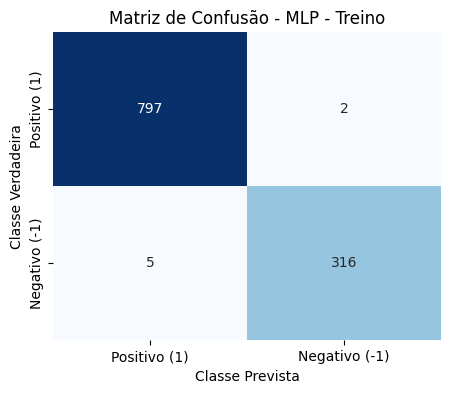

MLP - Teste - Resultados da Classificação:

Matriz de Confusão (formato solicitado):
[[201   0]
 [  1  78]]

Acurácia: 0.996
Sensibilidade (Recall da classe positiva): 1.000
Especificidade (Recall da classe negativa): 0.987
Precisão: 0.995
F1 Score: 0.998



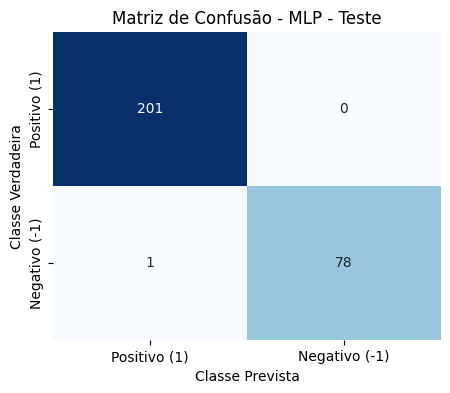

In [54]:
# Predição
Y_pred_train_raw = mlp.predict(X_train)
Y_pred_test_raw  = mlp.predict(X_test)

# Convertendo saída para {-1,1}
y_pred_train_mlp = np.where(Y_pred_train_raw[0,:] >= 0, 1, -1)
y_pred_test_mlp  = np.where(Y_pred_test_raw[0,:] >= 0, 1, -1)

# Matrizes de confusão
cm_train_mlp = confusion_matrix_manual(y_train, y_pred_train_mlp)
cm_test_mlp  = confusion_matrix_manual(y_test, y_pred_test_mlp)

# Métricas
acc_train_mlp, sens_train_mlp, spec_train_mlp, prec_train_mlp, f1_train_mlp = metrics(cm_train_mlp)
acc_test_mlp, sens_test_mlp, spec_test_mlp, prec_test_mlp, f1_test_mlp = metrics(cm_test_mlp)

# Mostrar resultados com heatmap
show_classification_results("MLP - Treino", cm_train_mlp, acc_train_mlp, sens_train_mlp, spec_train_mlp, prec_train_mlp, f1_train_mlp)
show_classification_results("MLP - Teste", cm_test_mlp, acc_test_mlp, sens_test_mlp, spec_test_mlp, prec_test_mlp, f1_test_mlp)

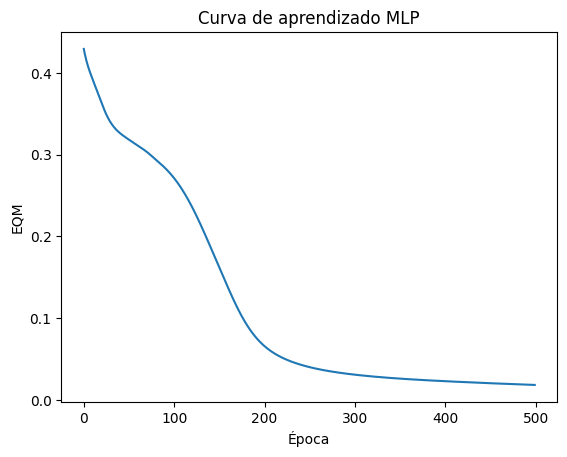

In [55]:
plt.figure()
plt.plot(mlp.history)
plt.xlabel("Época")
plt.ylabel("EQM")
plt.title("Curva de aprendizado MLP")
plt.show()

### Underfitting

In [65]:
mlp_underfitting = MultilayerPerceptron(X_train=X_train, Y_train=Y_train_mlp, topology=[10], learning_rate=0.000005, max_epoch=500)
mlp_underfitting.fit()

Rede MLP com 41 parâmetros
Tempo: 0.07398s  Época: 1, EQM: 0.404664607723615
Tempo: 0.08204s  Época: 2, EQM: 0.403224528316136
Tempo: 0.07425s  Época: 3, EQM: 0.401827850557641
Tempo: 0.07337s  Época: 4, EQM: 0.400473240007627
Tempo: 0.07199s  Época: 5, EQM: 0.399159375171424
Tempo: 0.07019s  Época: 6, EQM: 0.397884951154367
Tempo: 0.06992s  Época: 7, EQM: 0.396648682836206
Tempo: 0.07181s  Época: 8, EQM: 0.395449307595956
Tempo: 0.07239s  Época: 9, EQM: 0.394285587618811
Tempo: 0.07104s  Época: 10, EQM: 0.393156311817511
Tempo: 0.07139s  Época: 11, EQM: 0.392060297400520
Tempo: 0.07149s  Época: 12, EQM: 0.390996391118906
Tempo: 0.06884s  Época: 13, EQM: 0.389963470222839
Tempo: 0.06956s  Época: 14, EQM: 0.388960443157377
Tempo: 0.06883s  Época: 15, EQM: 0.387986250025693
Tempo: 0.07080s  Época: 16, EQM: 0.387039862846246
Tempo: 0.06919s  Época: 17, EQM: 0.386120285628575
Tempo: 0.07123s  Época: 18, EQM: 0.385226554290675
Tempo: 0.06861s  Época: 19, EQM: 0.384357736438962
Tempo: 0.0737

MLP - Treino - Resultados da Classificação:

Matriz de Confusão (formato solicitado):
[[639 160]
 [118 203]]

Acurácia: 0.752
Sensibilidade (Recall da classe positiva): 0.800
Especificidade (Recall da classe negativa): 0.632
Precisão: 0.844
F1 Score: 0.821



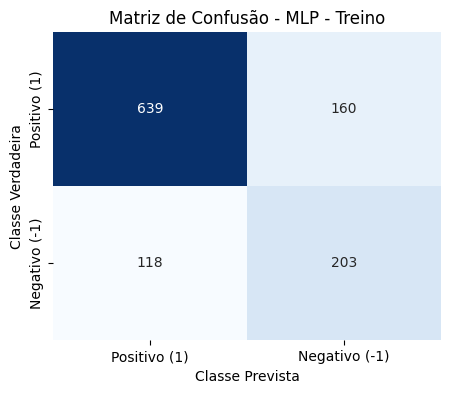

MLP - Teste - Resultados da Classificação:

Matriz de Confusão (formato solicitado):
[[165  36]
 [ 29  50]]

Acurácia: 0.768
Sensibilidade (Recall da classe positiva): 0.821
Especificidade (Recall da classe negativa): 0.633
Precisão: 0.851
F1 Score: 0.835



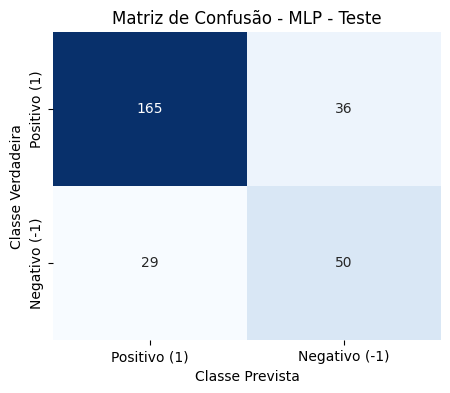

In [66]:
# Predição
Y_pred_train_raw_underfitting = mlp_underfitting.predict(X_train)
Y_pred_test_raw  = mlp_underfitting.predict(X_test)

# Convertendo saída para {-1,1}
y_pred_train_mlp_underfitting = np.where(Y_pred_train_raw_underfitting[0,:] >= 0, 1, -1)
y_pred_test_mlp_underfitting  = np.where(Y_pred_test_raw[0,:] >= 0, 1, -1)

# Matrizes de confusão
cm_train_mlp_underfitting = confusion_matrix_manual(y_train, y_pred_train_mlp_underfitting)
cm_test_mlp_underfitting  = confusion_matrix_manual(y_test, y_pred_test_mlp_underfitting)

# Métricas
acc_train_mlp_underfitting, sens_train_mlp_underfitting, spec_train_mlp_underfitting, prec_train_mlp_underfitting, f1_train_mlp_underfitting = metrics(cm_train_mlp_underfitting)
acc_test_mlp_underfitting, sens_test_mlp_underfitting, spec_test_mlp_underfitting, prec_test_mlp_underfitting, f1_test_mlp_underfitting = metrics(cm_test_mlp_underfitting)

# Mostrar resultados com heatmap
show_classification_results("MLP - Treino", cm_train_mlp_underfitting, acc_train_mlp_underfitting, sens_train_mlp_underfitting, spec_train_mlp_underfitting, prec_train_mlp_underfitting, f1_train_mlp_underfitting)
show_classification_results("MLP - Teste", cm_test_mlp_underfitting, acc_test_mlp_underfitting, sens_test_mlp_underfitting, spec_test_mlp_underfitting, prec_test_mlp_underfitting, f1_test_mlp_underfitting)

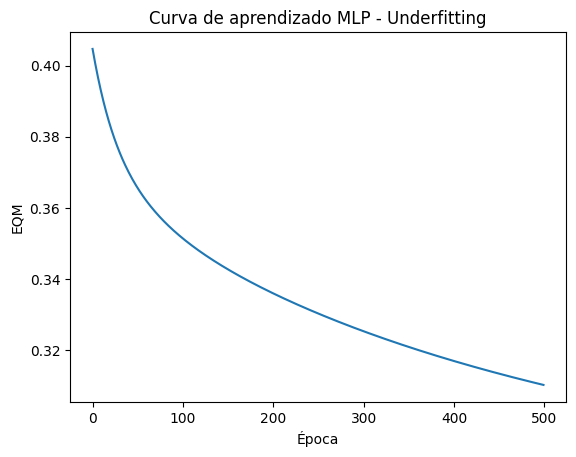

In [67]:
plt.figure()
plt.plot(mlp_underfitting.history)
plt.xlabel("Época")
plt.ylabel("EQM")
plt.title("Curva de aprendizado MLP - Underfitting")
plt.show()

### Overfitting

In [92]:
mlp_overfitting = MultilayerPerceptron(X_train=X_train, Y_train=Y_train_mlp, topology=[20, 10], learning_rate=0.00001, max_epoch=800)
mlp_overfitting.fit()

Rede MLP com 281 parâmetros
Tempo: 0.11627s  Época: 1, EQM: 0.640444778557299
Tempo: 0.14296s  Época: 2, EQM: 0.637717453983723
Tempo: 0.19877s  Época: 3, EQM: 0.635004261618246
Tempo: 0.14380s  Época: 4, EQM: 0.632305446827028
Tempo: 0.13881s  Época: 5, EQM: 0.629621246151332
Tempo: 0.13129s  Época: 6, EQM: 0.626951887239449
Tempo: 0.13111s  Época: 7, EQM: 0.624297588793385
Tempo: 0.13013s  Época: 8, EQM: 0.621658560530022
Tempo: 0.13433s  Época: 9, EQM: 0.619035003156571
Tempo: 0.13509s  Época: 10, EQM: 0.616427108359966
Tempo: 0.13251s  Época: 11, EQM: 0.613835058809918
Tempo: 0.12527s  Época: 12, EQM: 0.611259028175235
Tempo: 0.13420s  Época: 13, EQM: 0.608699181153027
Tempo: 0.12417s  Época: 14, EQM: 0.606155673510365
Tempo: 0.13565s  Época: 15, EQM: 0.603628652137949
Tempo: 0.12601s  Época: 16, EQM: 0.601118255115318
Tempo: 0.13168s  Época: 17, EQM: 0.598624611787082
Tempo: 0.12674s  Época: 18, EQM: 0.596147842849702
Tempo: 0.13013s  Época: 19, EQM: 0.593688060448260
Tempo: 0.115

MLP - Treino - Resultados da Classificação:

Matriz de Confusão (formato solicitado):
[[721  78]
 [154 167]]

Acurácia: 0.793
Sensibilidade (Recall da classe positiva): 0.902
Especificidade (Recall da classe negativa): 0.520
Precisão: 0.824
F1 Score: 0.861



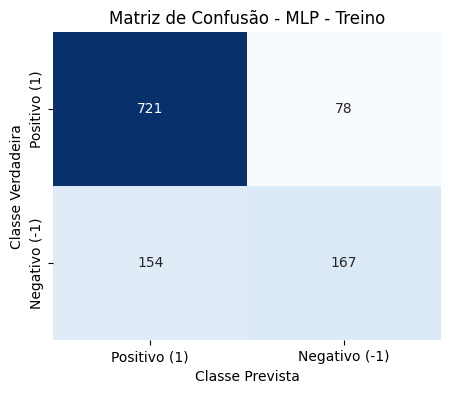

MLP - Teste - Resultados da Classificação:

Matriz de Confusão (formato solicitado):
[[180  21]
 [ 37  42]]

Acurácia: 0.793
Sensibilidade (Recall da classe positiva): 0.896
Especificidade (Recall da classe negativa): 0.532
Precisão: 0.829
F1 Score: 0.861



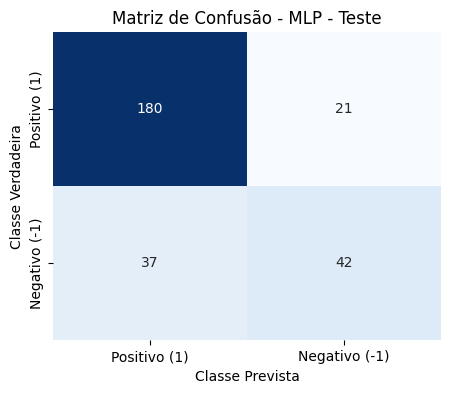

In [93]:
# Predição
Y_pred_train_raw_overfitting = mlp_overfitting.predict(X_train)
Y_pred_test_raw  = mlp_overfitting.predict(X_test)

# Convertendo saída para {-1,1}
y_pred_train_mlp_overfitting = np.where(Y_pred_train_raw_overfitting[0,:] >= 0, 1, -1)
y_pred_test_mlp_overfitting  = np.where(Y_pred_test_raw[0,:] >= 0, 1, -1)

# Matrizes de confusão
cm_train_mlp_overfitting = confusion_matrix_manual(y_train, y_pred_train_mlp_overfitting)
cm_test_mlp_overfitting  = confusion_matrix_manual(y_test, y_pred_test_mlp_overfitting)

# Métricas
acc_train_mlp_overfitting, sens_train_mlp_overfitting, spec_train_mlp_overfitting, prec_train_mlp_overfitting, f1_train_mlp_overfitting = metrics(cm_train_mlp_overfitting)
acc_test_mlp_overfitting, sens_test_mlp_overfitting, spec_test_mlp_overfitting, prec_test_mlp_overfitting, f1_test_mlp_overfitting = metrics(cm_test_mlp_overfitting)

# Mostrar resultados com heatmap
show_classification_results("MLP - Treino", cm_train_mlp_overfitting, acc_train_mlp_overfitting, sens_train_mlp_overfitting, spec_train_mlp_overfitting, prec_train_mlp_overfitting, f1_train_mlp_overfitting)
show_classification_results("MLP - Teste", cm_test_mlp_overfitting, acc_test_mlp_overfitting, sens_test_mlp_overfitting, spec_test_mlp_overfitting, prec_test_mlp_overfitting, f1_test_mlp_overfitting)

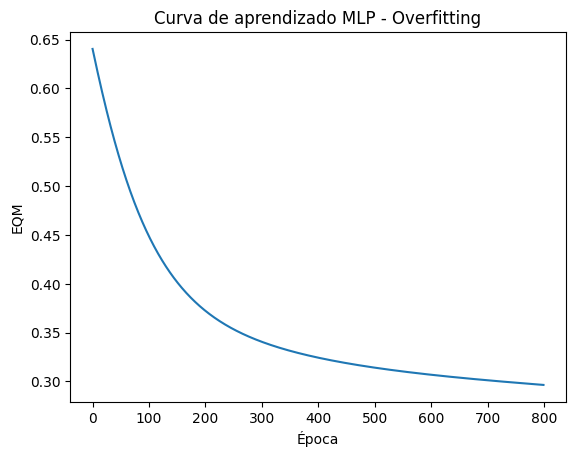

In [94]:
plt.figure()
plt.plot(mlp_overfitting.history)
plt.xlabel("Época")
plt.ylabel("EQM")
plt.title("Curva de aprendizado MLP - Overfitting")
plt.show()